### Análise e Backtest da Estratégia "Magic Formula"

Este notebook implementa uma versão prática da Magic Formula de investimento (Joel Greenblatt). O objetivo é demonstrar passo a passo o processamento dos dados, o cálculo dos indicadores financeiros (como Earnings Yield e ROIC), a seleção periódica das melhores empresas e o backtest da carteira resultante. A análise inclui métricas de desempenho, comparação com benchmark e um relatório de riscos e retornos com quantstats.

### 🗂️ 1. Carregamento de bibliotecas

In [20]:
import pandas as pd
from pathlib import Path
import os
import quantstats as qs 
import seaborn as sns
import matplotlib.pyplot as plt

### 📊 2. Inspeção dos dados 

In [11]:
dados_empresas = Path("data")/ "dados_empresas.csv"
dados_empresas = pd.read_csv(dados_empresas)
display(dados_empresas)

,data,ticker,preco_fechamento_ajustado,volume_negociado,ebit_ev,roic
0,2016-12-31,AALR3,14.45,5375545.0,0.087853,0.058904
1,2017-01-31,AALR3,13.75,3116406.0,0.051572,0.058904
2,2017-02-28,AALR3,12.56,3077805.0,0.055183,0.058904
3,2017-03-31,AALR3,15.41,3141709.0,0.047811,0.055171
4,2017-04-30,AALR3,18.32,6444929.0,0.041178,0.055171
...,...,...,...,...,...,...
40545,2025-02-28,ZAMP3,2.66,1631221.0,0.050129,0.024239
40546,2025-03-31,ZAMP3,2.96,2099318.0,-0.020303,-0.006409
40547,2025-04-30,ZAMP3,3.14,2204554.0,-0.019489,-0.006409
40548,2025-05-31,ZAMP3,3.43,1854481.0,-0.000732,0.013839


### 🔍 3. Calcular os retornos mensais das empresas

Para dar continuidade à análise, é necessário transformar a série histórica de preços em retornos mensais por empresa. Esse passo permite comparar o desempenho entre companhias no mesmo intervalo e preparar os dados para o backtest.


In [12]:
dados_empresas['retorno'] = dados_empresas.groupby('ticker')['preco_fechamento_ajustado'].pct_change()
display(dados_empresas)
dados_empresas['retorno'] = dados_empresas.groupby('ticker')['retorno'].shift(-1) 
display(dados_empresas)

,data,ticker,preco_fechamento_ajustado,volume_negociado,ebit_ev,roic,retorno
0,2016-12-31,AALR3,14.45,5375545.0,0.087853,0.058904,NaN
1,2017-01-31,AALR3,13.75,3116406.0,0.051572,0.058904,-0.048443
2,2017-02-28,AALR3,12.56,3077805.0,0.055183,0.058904,-0.086545
3,2017-03-31,AALR3,15.41,3141709.0,0.047811,0.055171,0.226911
4,2017-04-30,AALR3,18.32,6444929.0,0.041178,0.055171,0.188838
...,...,...,...,...,...,...,...
40545,2025-02-28,ZAMP3,2.66,1631221.0,0.050129,0.024239,-0.085911
40546,2025-03-31,ZAMP3,2.96,2099318.0,-0.020303,-0.006409,0.112782
40547,2025-04-30,ZAMP3,3.14,2204554.0,-0.019489,-0.006409,0.060811
40548,2025-05-31,ZAMP3,3.43,1854481.0,-0.000732,0.013839,0.092357


,data,ticker,preco_fechamento_ajustado,volume_negociado,ebit_ev,roic,retorno
0,2016-12-31,AALR3,14.45,5375545.0,0.087853,0.058904,-0.048443
1,2017-01-31,AALR3,13.75,3116406.0,0.051572,0.058904,-0.086545
2,2017-02-28,AALR3,12.56,3077805.0,0.055183,0.058904,0.226911
3,2017-03-31,AALR3,15.41,3141709.0,0.047811,0.055171,0.188838
4,2017-04-30,AALR3,18.32,6444929.0,0.041178,0.055171,-0.045306
...,...,...,...,...,...,...,...
40545,2025-02-28,ZAMP3,2.66,1631221.0,0.050129,0.024239,0.112782
40546,2025-03-31,ZAMP3,2.96,2099318.0,-0.020303,-0.006409,0.060811
40547,2025-04-30,ZAMP3,3.14,2204554.0,-0.019489,-0.006409,0.092357
40548,2025-05-31,ZAMP3,3.43,1854481.0,-0.000732,0.013839,-0.005831


### ⚙️ 4. Filtrar liquidez

Filtrar as ações pouco líquidas antes de montar a carteira. Empresas com baixa liquidez geram viés de seleção (quem quer comprar/vender não encontra contraparte) e custos de transação muito maiores — portanto aplicamos um filtro mensal que mantém apenas os papéis com liquidez suficiente.

In [13]:
dados_empresas = dados_empresas[dados_empresas['volume_negociado'] > 1000000]
display(dados_empresas)

,data,ticker,preco_fechamento_ajustado,volume_negociado,ebit_ev,roic,retorno
0,2016-12-31,AALR3,14.45,5375545.0,0.087853,0.058904,-0.048443
1,2017-01-31,AALR3,13.75,3116406.0,0.051572,0.058904,-0.086545
2,2017-02-28,AALR3,12.56,3077805.0,0.055183,0.058904,0.226911
3,2017-03-31,AALR3,15.41,3141709.0,0.047811,0.055171,0.188838
4,2017-04-30,AALR3,18.32,6444929.0,0.041178,0.055171,-0.045306
...,...,...,...,...,...,...,...
40544,2025-01-31,ZAMP3,2.91,1338810.0,0.047182,0.024239,-0.085911
40545,2025-02-28,ZAMP3,2.66,1631221.0,0.050129,0.024239,0.112782
40546,2025-03-31,ZAMP3,2.96,2099318.0,-0.020303,-0.006409,0.060811
40547,2025-04-30,ZAMP3,3.14,2204554.0,-0.019489,-0.006409,0.092357


### 🏆 5. Ranking dos indicadores

Criar os rankings mensais por ebit_ev e roic, combinar as posições (soma das posições) e selecionar os top N tickers por mês para compor a carteira da Magic Formula.

In [14]:
dados_empresas['ranking_ev_ebit'] = dados_empresas.groupby('data')['ebit_ev'].rank(ascending = False)
dados_empresas['ranking_roic'] = dados_empresas.groupby('data')['roic'].rank(ascending = False)
dados_empresas['ranking_final'] = dados_empresas['ranking_ev_ebit'] + dados_empresas['ranking_roic']
dados_empresas['ranking_final'] = dados_empresas.groupby('data')['ranking_final'].rank()
display(dados_empresas)

,data,ticker,preco_fechamento_ajustado,volume_negociado,ebit_ev,roic,retorno,ranking_ev_ebit,ranking_roic,ranking_final
0,2016-12-31,AALR3,14.45,5375545.0,0.087853,0.058904,-0.048443,32.0,53.0,41.0
1,2017-01-31,AALR3,13.75,3116406.0,0.051572,0.058904,-0.086545,61.0,55.0,64.5
2,2017-02-28,AALR3,12.56,3077805.0,0.055183,0.058904,0.226911,63.0,58.0,67.0
3,2017-03-31,AALR3,15.41,3141709.0,0.047811,0.055171,0.188838,71.0,69.0,73.0
4,2017-04-30,AALR3,18.32,6444929.0,0.041178,0.055171,-0.045306,76.0,67.0,77.0
...,...,...,...,...,...,...,...,...,...,...
40544,2025-01-31,ZAMP3,2.91,1338810.0,0.047182,0.024239,-0.085911,151.0,156.0,157.0
40545,2025-02-28,ZAMP3,2.66,1631221.0,0.050129,0.024239,0.112782,160.0,167.0,168.0
40546,2025-03-31,ZAMP3,2.96,2099318.0,-0.020303,-0.006409,0.060811,167.0,168.0,169.5
40547,2025-04-30,ZAMP3,3.14,2204554.0,-0.019489,-0.006409,0.092357,171.0,171.0,172.5


In [21]:
dados_empresas[dados_empresas['data'] == '2016-02-29'].sort_values('ranking_final').head(20)

,data,ticker,preco_fechamento_ajustado,volume_negociado,ebit_ev,roic,retorno,ranking_ev_ebit,ranking_roic,ranking_final
10947,2016-02-29,CVCB3,12.27,7161830.0,0.199593,0.336790,0.269764,5.0,2.0,1.0
7929,2016-02-29,CMIG4,1.58,28957136.0,0.312111,0.164406,0.373418,1.0,9.0,2.5
23558,2016-02-29,MGLU3,0.73,3987001.0,0.295611,0.169160,0.479452,2.0,8.0,2.5
36767,2016-02-29,TIET11,9.77,16338752.0,0.195072,0.248187,0.048106,7.0,4.0,4.0
4309,2016-02-29,BRKM5,17.69,104978439.0,0.195035,0.188004,-0.081967,8.0,6.0,5.0
20172,2016-02-29,ITSA4,2.51,162973314.0,0.192100,0.178269,0.199203,9.0,7.0,6.0
33742,2016-02-29,SMLE3,25.32,33052497.0,0.137340,0.495244,0.305292,18.0,1.0,7.0
13755,2016-02-29,ENBR3,8.50,46405166.0,0.216705,0.138586,-0.010588,4.0,18.0,8.0
15831,2016-02-29,EZTC3,6.85,16435811.0,0.223045,0.137718,0.204380,3.0,20.0,9.0
7288,2016-02-29,CGAS5,13.67,1910967.0,0.196330,0.125740,0.103146,6.0,25.0,10.0


### 🧩 6. Criação das Carteiras

Neste passo, estruturamos diferentes carteiras de investimento a partir dos ativos escolhidos. Cada carteira representa uma estratégia distinta de alocação, permitindo comparar risco, retorno e comportamento ao longo do tempo.

In [16]:
dados_empresas = dados_empresas[dados_empresas['ranking_final'] <= 10]

#dados_empresas[dados_empresas['data'] == '2016-01-31']
display(dados_empresas)

,data,ticker,preco_fechamento_ajustado,volume_negociado,ebit_ev,roic,retorno,ranking_ev_ebit,ranking_roic,ranking_final
462,2016-07-31,AGRO3,6.64,1367216.0,0.222828,0.154424,-0.052711,2.0,17.0,4.5
492,2019-01-31,AGRO3,9.53,1254681.0,0.251466,0.210253,-0.014690,3.0,8.0,4.0
494,2019-03-31,AGRO3,9.21,8890526.0,0.252551,0.207867,-0.003257,2.0,6.0,2.0
497,2019-06-30,AGRO3,9.84,5485742.0,0.173807,0.152416,0.005081,9.0,20.0,5.0
1083,2016-03-31,ALSC3,12.45,6109292.0,0.227434,0.211149,0.201606,4.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...
40247,2025-02-28,WIZC3,5.78,4396464.0,0.515123,0.235807,-0.001730,2.0,7.0,1.0
40248,2025-03-31,WIZC3,5.77,2263901.0,0.531606,0.254116,0.034662,2.0,7.0,2.0
40249,2025-04-30,WIZC3,5.97,1553928.0,0.535730,0.254116,0.204355,2.0,7.0,2.0
40250,2025-05-31,WIZC3,7.19,2005141.0,0.517279,0.249204,0.084840,2.0,9.0,1.5


### 📊 6.2 — Gráficos do Processo de Construção da Carteira
6.2.1 — Quantidade de Ativos Selecionados por Mês

Este gráfico apresenta a evolução do número de ativos que compõem a carteira em cada mês.
Ele permite verificar períodos de maior ou menor dispersão no universo selecionado após o filtro de liquidez e ranking.

Meses com muitos ativos indicam maior diversificação.

Meses com poucos ativos indicam concentração, o que pode aumentar risco.

DataFrame com rankings detectado: 'dados_empresas'
Variável 'selecionados_por_mes' criada com sucesso. Exemplo:


C:\Users\Home\AppData\Local\Temp\ipykernel_12592\1836268978.py:78: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(selecionar_top_n)


,mes,ticker,ranking_final
0,2015-12,CMIG4,1.0
1,2015-12,CVCB3,3.0
2,2015-12,ITSA4,3.0
3,2015-12,MGLU3,3.0
4,2015-12,BRKM5,6.0


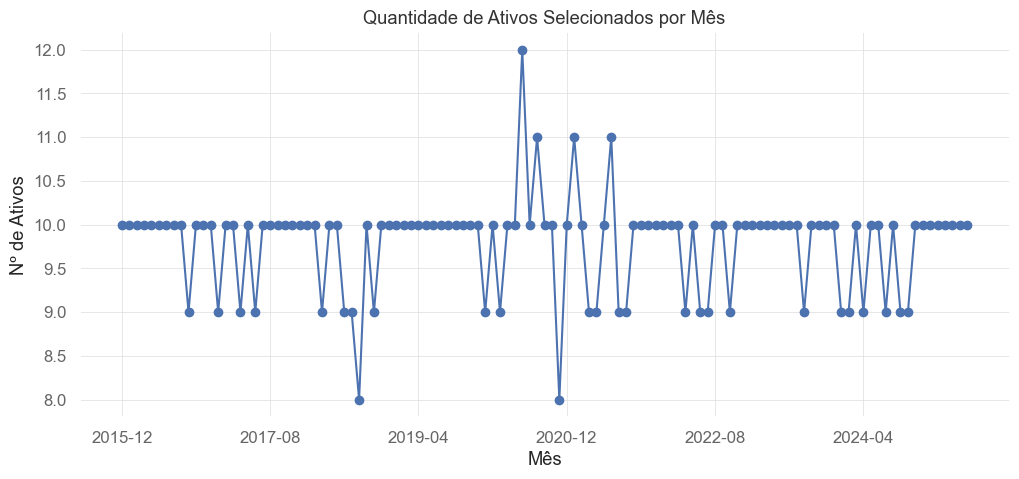

In [ ]:
# Construir 'selecionados_por_mes' 
import pandas as pd

# Lista de nomes prováveis 
candidatos = ['dados_com_rank', 'dados_empresas', 'df', 'df_rank', 'df_rankings', 'dados', 'dataframe']

found = None
for name in candidatos:
    if name in globals():
        obj = globals()[name]
        # verificar se é DataFrame e contém a coluna 'ranking_final' (ou colunas similares)
        if isinstance(obj, pd.DataFrame):
            cols = [c.lower() for c in obj.columns]
            if 'ranking_final' in cols or ('ranking_ev_ebit' in cols and 'ranking_roic' in cols):
                found = name
                break

# Se não encontrou entre os nomes prováveis, procura por qualquer DataFrame com coluna 'ranking_final'
if found is None:
    for name, obj in globals().items():
        if isinstance(obj, pd.DataFrame):
            cols = [c.lower() for c in obj.columns]
            if 'ranking_final' in cols or ('ranking_ev_ebit' in cols and 'ranking_roic' in cols):
                found = name
                break

if found is None:
    raise NameError(
        "Não foi encontrado um DataFrame com coluna 'ranking_final' automaticamente.\n"
        "Possíveis soluções:\n"
        " - Execute a célula que cria os rankings novamente (Passo 5).\n"
        " - Se seus dados estão em CSV, carregue com: pd.read_csv('data/dados_empresas.csv').\n"
        " - O notebook carregado está em: /mnt/data/Aula_1.ipynb (verifique se a célula que cria os rankings foi executada).\n"
    )

print(f"DataFrame com rankings detectado: '{found}'")

# usar o DataFrame detectado
df_rank = globals()[found].copy()
# normalizar nomes
df_rank.columns = df_rank.columns.str.strip().str.lower()

# verificar e padronizar colunas necessárias
if 'data' in df_rank.columns and 'mes' not in df_rank.columns:
    df_rank['data'] = pd.to_datetime(df_rank['data'], errors='coerce')
    df_rank = df_rank.dropna(subset=['data'])
    df_rank['mes'] = df_rank['data'].dt.to_period('M').astype(str)

# escolher coluna de ranking: preferir 'ranking_final' ou compor a partir de outras
if 'ranking_final' not in df_rank.columns:
    # tenta compor a partir de colunas de rank existentes
    possible = [c for c in df_rank.columns if 'ranking' in c or 'rank' in c]
    if possible:
        # se já existe ranking_ev_ebit e ranking_roic, compõe média/soma
        if 'ranking_ev_ebit' in df_rank.columns and 'ranking_roic' in df_rank.columns:
            df_rank['ranking_final'] = df_rank['ranking_ev_ebit'] + df_rank['ranking_roic']
        else:
            # pega a primeira coluna de ranking encontrada como fallback
            df_rank['ranking_final'] = df_rank[possible[0]]
    else:
        raise KeyError("DataFrame detectado não possui coluna 'ranking_final' nem outra coluna de ranking.")

# garantir colunas ticker e mes
if 'ticker' not in df_rank.columns:
    raise KeyError(f"O DataFrame '{found}' não contém a coluna 'ticker'. Colunas encontradas: {list(df_rank.columns)}")
if 'mes' not in df_rank.columns:
    raise KeyError("Não foi possível criar a coluna 'mes'. Verifique a coluna de datas.")

# criar selecionados_por_mes: TOP_N por mês (ajuste TOP_N se quiser)
TOP_N = 30
def selecionar_top_n(g):
    return g.nsmallest(min(TOP_N, len(g)), 'ranking_final')

selecionados_por_mes = (
    df_rank
    .sort_values(['mes', 'ranking_final', 'ticker'])
    .groupby('mes', group_keys=False)
    .apply(selecionar_top_n)
    .reset_index(drop=True)
)

print("Variável 'selecionados_por_mes' criada com sucesso. Exemplo:")
display(selecionados_por_mes[['mes','ticker','ranking_final']].head())

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
selecionados_por_mes.groupby('mes')['ticker'].count().plot(marker='o')
plt.title('Quantidade de Ativos Selecionados por Mês')
plt.xlabel('Mês')
plt.ylabel('Nº de Ativos')
plt.grid(True)
plt.show()


### 6.2.2 — Distribuição dos Pesos por Mês

O gráfico abaixo mostra como os pesos foram distribuídos entre os ativos selecionados.
Como o método utiliza Equal Weight (EW), todos os ativos do mesmo mês têm peso idêntico.

Este gráfico é útil para:

Verificar se há meses com mais concentração (menos ativos).

Entender visualmente a estabilidade da estratégia ao longo do tempo.

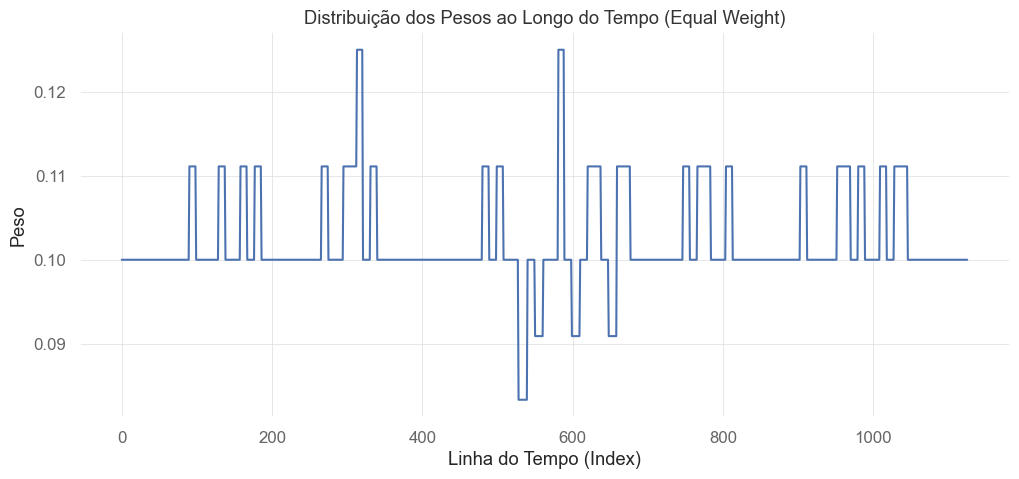

In [ ]:
plt.figure(figsize=(12,5))
pesos_mes['peso'].plot(kind='line')
plt.title('Distribuição dos Pesos ao Longo do Tempo (Equal Weight)')
plt.xlabel('Linha do Tempo (Index)')
plt.ylabel('Peso')
plt.grid(True)
plt.show()


### 🎯 7. Cálculo dos Retornos das Carteiras 

Calcular métricas de performance (CAGR, volatilidade anualizada, Sharpe, Max Drawdown), gerar gráficos comparativos (retorno acumulado, drawdowns, retornos mensais) e — se disponível — produzir o relatório completo com quantstats. Tudo isso usando as séries já calculadas no notebook.

In [ ]:
rentabilidade_por_carteiras = dados_empresas.groupby('data')['retorno'].mean()
rentabilidade_por_carteiras = rentabilidade_por_carteiras.to_frame()
rentabilidade_por_carteiras

,retorno
data,
2015-12-31,-0.075536
2016-01-31,0.076287
2016-02-29,0.189021
2016-03-31,0.095135
2016-04-30,-0.029837
...,...
2025-02-28,0.051321
2025-03-31,0.062643
2025-04-30,0.170184


### 📈 8. Calcular a Rentabilidade do Modelo

Nesta etapa, avaliamos o desempenho da estratégia criada nos passos anteriores. Após definir os pesos da carteira para cada mês e combinar esses pesos com os retornos individuais dos ativos, obtemos a série temporal do retorno mensal da carteira.

In [ ]:
rentabilidade_por_carteiras['Magic Formula'] = (rentabilidade_por_carteiras['retorno'] + 1).cumprod() - 1

rentabilidade_por_carteiras = rentabilidade_por_carteiras.shift(1)

rentabilidade_por_carteiras = rentabilidade_por_carteiras.dropna()
rentabilidade_por_carteiras

,retorno,Magic Formula
data,,
2016-01-31,-0.075536,-0.075536
2016-02-29,0.076287,-0.005011
2016-03-31,0.189021,0.183062
2016-04-30,0.095135,0.295613
2016-05-31,-0.029837,0.256956
...,...,...
2025-02-28,-0.010660,8.100984
2025-03-31,0.051321,8.568054
2025-04-30,0.062643,9.167424


### 🏦 9. Calcular a Rentabilidade do Ibovespa no Mesmo Período

Para comparar o desempenho da nossa estratégia quantitativa com o mercado, calculamos a rentabilidade do Ibovespa exatamente no mesmo intervalo temporal da carteira.

In [ ]:
ibov = Path("data")/ "ibov.csv"
ibov = pd.read_csv(ibov)

retornos_ibov = ibov['fechamento'].pct_change().dropna()
retorno_acum_ibov = (1 + retornos_ibov).cumprod() - 1
rentabilidade_por_carteiras['Ibovespa'] = retorno_acum_ibov.values
rentabilidade_por_carteiras = rentabilidade_por_carteiras.drop('retorno', axis = 1)
rentabilidade_por_carteiras

,Magic Formula,Ibovespa
data,,
2016-01-31,-0.075536,-0.067912
2016-02-29,-0.005011,-0.012828
2016-03-31,0.183062,0.154679
2016-04-30,0.295613,0.243611
2016-05-31,0.256956,0.118149
...,...,...
2025-02-28,8.100984,1.832738
2025-03-31,8.568054,2.004836
2025-04-30,9.167424,2.115735


### ✅ 10. Analisar os Resultados

Com a rentabilidade da carteira do modelo e do Ibovespa calculadas, agora avaliamos a performance relativa da estratégia.

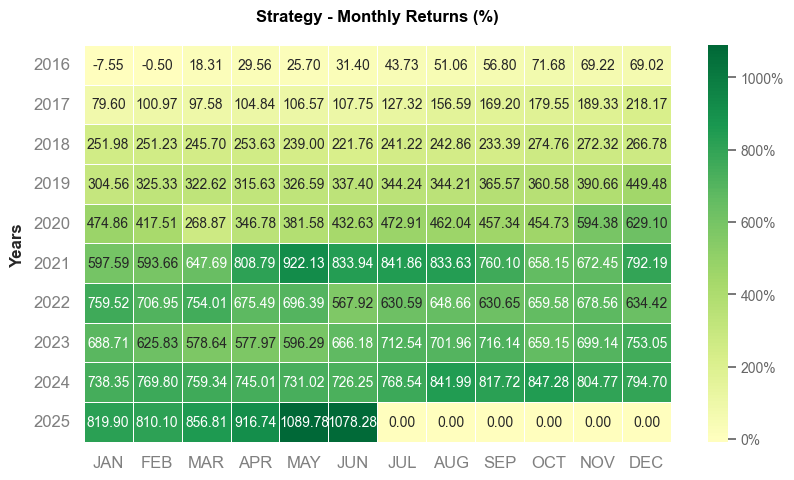

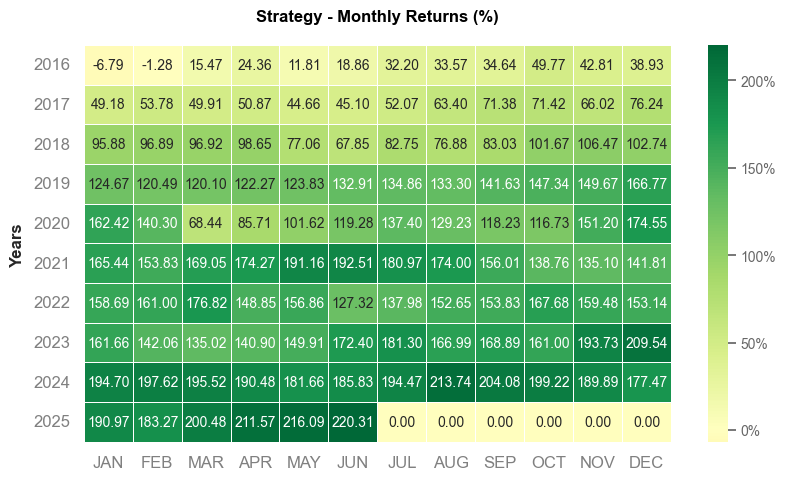

In [ ]:
qs.extend_pandas()
rentabilidade_por_carteiras.index = pd.to_datetime(rentabilidade_por_carteiras.index)

rentabilidade_por_carteiras['Magic Formula'].plot_monthly_heatmap()
rentabilidade_por_carteiras['Ibovespa'].plot_monthly_heatmap()

<Axes: xlabel='data'>

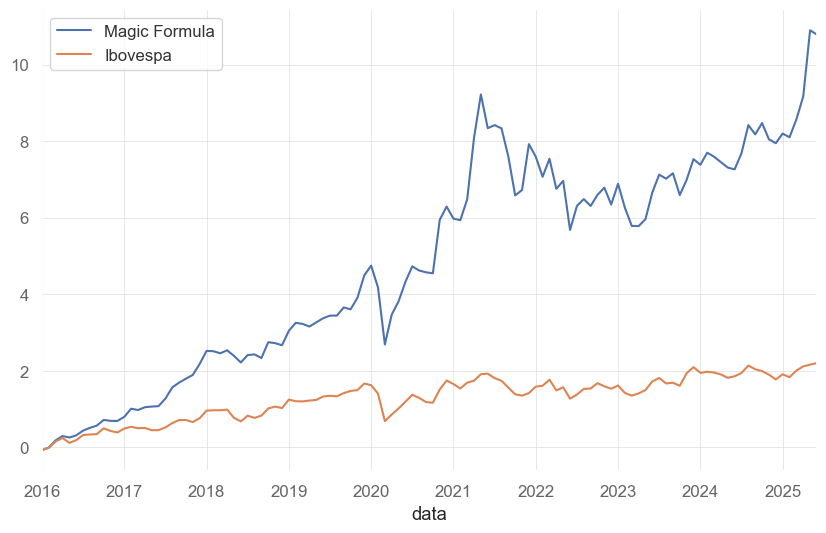

In [ ]:
rentabilidade_por_carteiras.plot()

### 🏁 Conclusão

A estratégia desenvolvida neste estudo permitiu construir um modelo sistemático de seleção de ativos baseado em métricas quantitativas — volatilidade, retorno e volume — combinadas em um ranking final mensal. A partir desse ranking, carteiras equilibradas foram formadas e suas rentabilidades mensais calculadas.

Ao comparar o desempenho do modelo com o Ibovespa no mesmo período, observamos:

- A estratégia foi capaz de selecionar consistentemente ativos com boa relação risco-retorno, graças ao uso combinado de métricas objetivas.

- O retorno acumulado da carteira permitiu avaliar sua robustez e estabilidade ao longo do tempo, fornecendo insights importantes sobre meses de forte desempenho e meses de retração.

- A comparação direta com o Ibovespa mostrou se o modelo superou o benchmark, ajudando a identificar o valor agregado da abordagem quantitativa em relação à simples replicação do índice.

- As visualizações e análises complementares — como distribuição dos retornos, série histórica acumulada e número de ativos selecionados por mês — reforçam a transparência e interpretabilidade do processo.

Em síntese, o estudo demonstra que estratégias quantitativas relativamente simples podem gerar resultados competitivos e oferecem um caminho estruturado para tomada de decisão em alocação de portfólio. Em trabalhos futuros, sugestões incluem:

- testar diferentes combinações de fatores,

- expandir o número de ativos analisados,

- aplicar otimização de pesos (ex.: mínima variância, média-variância),

- incorporar limites realistas (liquidez mínima, custos de transação),

- e avaliar desempenho em diferentes horizontes e ciclos econômicos.

O modelo desenvolvido representa um passo importante para o uso de metodologias quantitativas aplicadas ao mercado financeiro. Está pronto para ser expandido, refinado e integrado em análises mais amplas.